In [ ]:
pip install phiflow

In [2]:
from phi.flow import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
domain = Box(x=10, y=10,z=10)
inflow = Sphere(x=5, y=0.95,z=5, radius=5)
inflow_rate = 0.2

@jit_compile
def step(v, s, p, dt):
    s = advect.mac_cormack(s, v, dt) + inflow_rate * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1, 0), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, (), Solve('CG', 1e-3, x0=p))
    return v, s, p

v0 = StaggeredGrid(0, 0, domain, x=32, y=32,z=32)
smoke0 = CenteredGrid(0, ZERO_GRADIENT, domain, x=20, y=20,z=20)
v_trj, s_trj, p_trj = iterate(step, batch(time=20), v0, smoke0, None,range=trange, dt=.5, substeps=3)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/phiml/math/_functional.py:280: RuntimeWarning: jit_copmile() not supported by numpy. Running function 'step' as-is.
  warnings.warn(f"jit_copmile() not supported by {key.backend}. Running function '{f_name(self.f)}' as-is.", RuntimeWarning)


In [40]:
plot(v_trj.time[1],s_trj.time[1])

/usr/local/lib/python3.10/dist-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



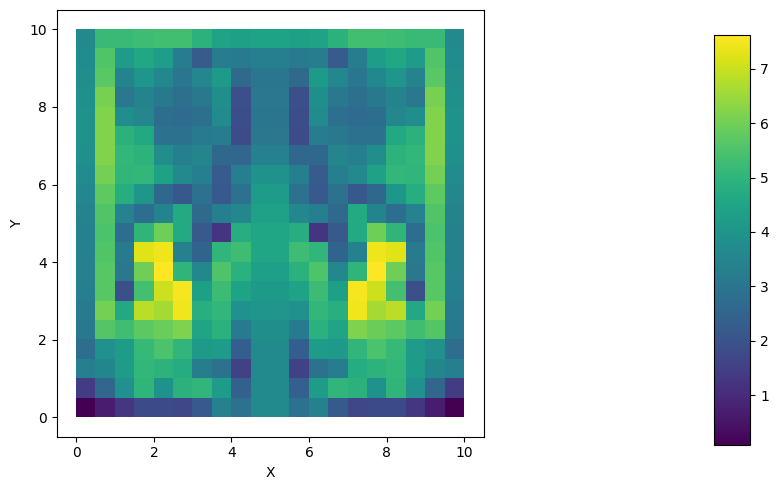

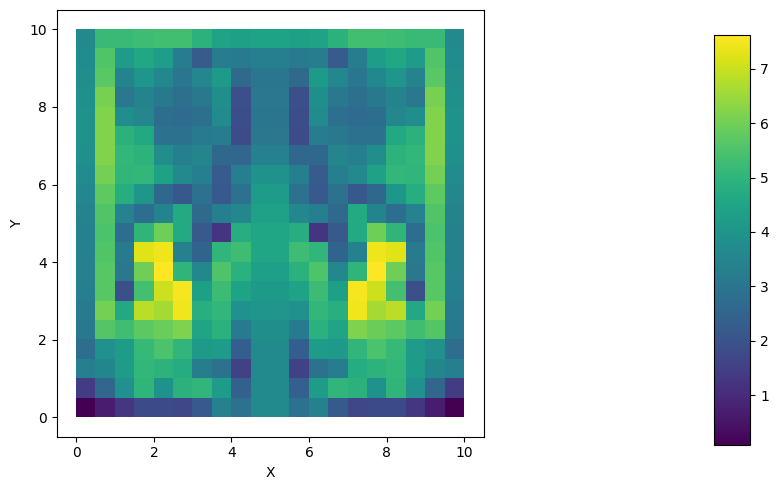

In [6]:
plot(s_trj.time[20].z[3])

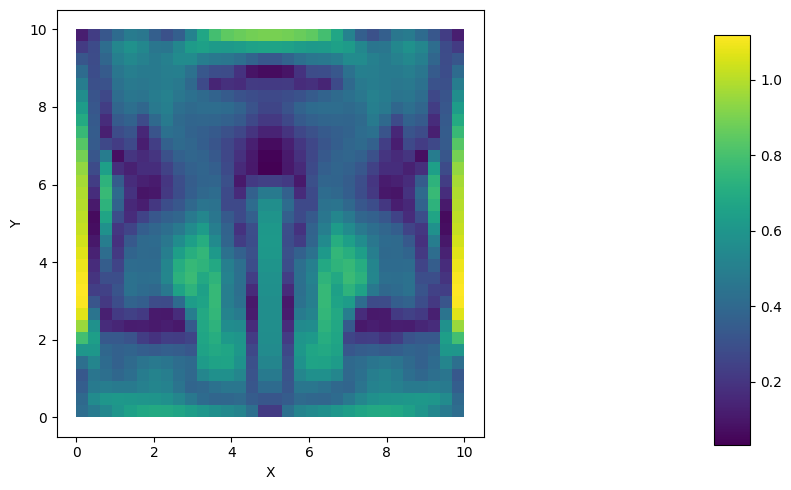

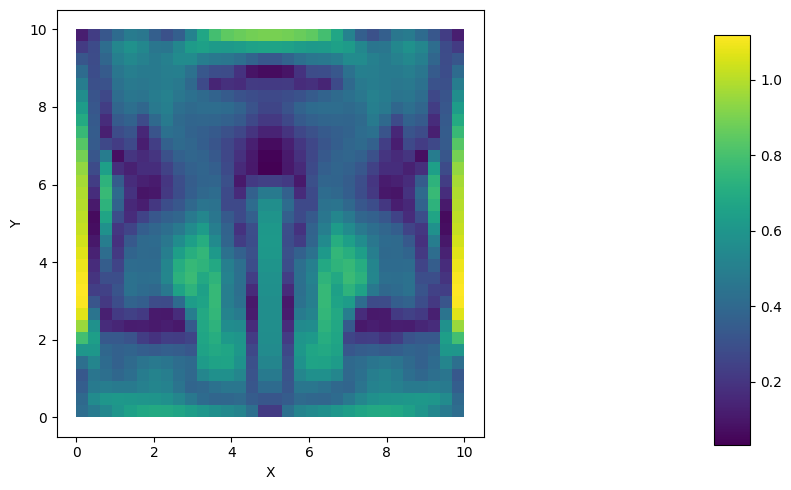

In [13]:
plot(math.vec_abs(v_trj.time[20].at_centers()).z[3])

In [51]:
from phi.flow import *
dt=.5
def combined_estimation(Φ_prev, u_prev):
    # 第1步：预测无散度速度场
    u_hat = Divergence_free(advect.semi_lagrangian(u_prev, u_prev, dt))
    # 第2步：预测密度场
    Φ_tilde = advect.mac_cormack(Φ_prev, u_hat,dt)
    calculate_update(Φ_tilde, abseryed_image-Φ_prev)
    return Φ_tilde

def Divergence_free(u):
    p = None  # 给 press 赋一个初值，可以是 None 或者其他合理值
    u_div_free, p = fluid.make_incompressible(u, (), Solve('CG', 1e-3, x0=p))
    return u_div_free  # 返回无散度的速度场

s=combined_estimation(s_trj.time[1],v_trj.time[1])

In [52]:
plot(s)

In [83]:
import numpy as np
from phi.flow import *
from scipy.sparse.linalg import inv
from scipy.sparse import coo_matrix
# 正则化参数
# 正则化参数
sigma_phi = 10        # 密度更新的正则化参数
sigma_u = 0.1         # 速度更新的正则化参数
sigma_phi_2 = 0.01    # 第二步密度更新的正则化参数

# 步长参数
tau_phi = 0.01        # 密度更新的步长参数
tau_u = 5             # 速度更新的步长参数
tau_phi_2 = 100       # 第二步密度更新的步长参数

# 动量参数
theta_phi = 1         # 密度更新的动量参数
theta_u = 1           # 速度更新的动量参数
theta_phi_2 = 1       # 第二步密度更新的动量参数
def prox_f_sigma_phi(xi):
    """
    实现 prox_f_sigma，用于二维密度场和速度场的更新。

    参数:
    - xi: 输入变量列表 [xi_density, xi_velocity]。
          xi_density: 二维密度场，形状 (H, W)。
          xi_velocity: 二维速度场，形状 (H, W, 2)，即包含两个分量 (u_x, u_y)。
    - sigma_phi: 密度正则化参数。
    - sigma_u: 速度正则化参数。

    返回值:
    - 更新结果列表 [updated_density, updated_velocity]。
    """
    # 分离 ξ 为密度部分和速度部分
    xi_density = xi
    field_numpy = xi_density.values.numpy('x,y,z')
    # ---- 1. 计算密度梯度 ----
    grad_density_x, grad_density_y,grad_density_z = np.gradient(field_numpy)
    grad_density_flat = np.vstack([
        grad_density_x.flatten(),
        grad_density_y.flatten(),
        grad_density_z.flatten()
    ])

    # 构造密度部分的矩阵 A_density
    grad_T = grad_density_flat.T  # grad_T.shape = (N_density, 3)
    N_density = xi_density.shape.volume
    I = np.eye(N_density)  # 单位矩阵
    upper_block = np.hstack([I, grad_T])  # 左上和右上部分
    lower_block = np.hstack([grad_density_flat, grad_density_flat @ grad_T])  # 左下和右下部分
    A = np.vstack([upper_block, lower_block])  # 组合为完整分块矩阵



    # ---- 3. 密度部分的求解 ----
    rhs_density = sigma_phi * xi_density.values.numpy('x,y,z').T.flatten()
    result_density = np.linalg.solve(A, rhs_density.)
    result_density = result_density.reshape(xi_density.shape)



    # 返回更新后的密度和速度部分
    return result_density
#print(s_trj.time[3].shape.volume)
prox_f_sigma_phi(s_trj.time[3])

SyntaxError: invalid syntax (<ipython-input-83-16f118d5b43a>, line 57)